# Introduction

This notebook contains all the code necessary to obtain the plots shown in the report. It will be divided in two section: the training/testing file division plot, and the cross-validation results plot. 

# Some definitions

In [35]:
# The number of subjects i nthe CHB-MIT data-set
SUBJECTS_N = 24
# The IDs of the subjects used in the baseline publication
SUBJECT_SUBSET = [1, 3, 5, 8, 12, 14, 15, 24]


# Definition of file names, paths, and name parts for parsing. 
# Summary files
recording_names_path        = "baseline/etc/indexes/index_all.txt"  # The list of all recordings
recording_sumaries_path     = "baseline/etc/summaries/"             # The path to the summary files
recording_sumaries_prologue = "chb"                                 # The prologue of the name of each summary file
recording_sumaries_epilogue = "-summary.txt"                        # The epilogue of the name of each summary file
# Line contents of the summaries's file
line_recording_name_start   = "File Name: chb"                      # Begining of a new recording.
line_recording_name_end     = ".edf\n"                              # Ending of the line containing the recording name.
line_seizures_start         = "Number of Seizures in File: "        # Begining of the line containing seizure count.  
line_seizures_time_start    = 'Seizure Start Time: '                # Begining of the line containing seizure start time
line_seizures_time_end      = 'Seizure End Time: '                  # Begining of the line containing seizure end time
line_seizures_seconds       = ' seconds\n'                          # Ending of the line containing seizure's time
# Indexes (which files will be used for training and which for testing)
selected_indexes_path_orig  = "baseline/indexes_detection/"         # The path to the original division
selected_indexes_path       = "baseline/indexes_detection/new/"     # The path to the new (proposed) division)
selected_indexes_prologue   = "../clean_signals/chb"                # Path and prologue of each signal file (wrt the indexes file)
selected_indexes_name_train = "train.txt"                           # Name of the training indexes file
selected_indexes_name_test  = "test.txt"                            # Name of the testing indexes file
selected_indexes_name_valid = "validation.txt"                      # Name of the validation indexes file (only for the original division)


# Training/testing file division

In the baseline repository the data-set for each subject was handpicked into training and testing subsets. This lead to to use of future data for training. 
The choice of recordings along with a new time-dependency respectful proposal is presented in a plot, showing recordings for each subject and highlighting the one containing seizures. 

## Load recordings and seizure count in each recording, for each subject
Firstly, the `summary` files of each subject are loaded. These contain a summary of the recordings and when they include an annotated seizure. 

In [36]:
import os

# Load the file containing the name of all recordings
with open(recording_names_path) as n: 
    names = n.readlines()
filename_recordings = [n.strip() for n in names]

# Will create a dictionary with the information for each subject. 
subjects = {}

# Subject's IDs are incremental for 01-24
for subject_idx in range(1, SUBJECTS_N + 1 ):
    subject_name = f"{subject_idx:02d}"             # Extract the subject name from the file name
    subjects[subject_name] = {}                     # Create a new sub-dictionary for each subject
    filename = recording_sumaries_path \
                + recording_sumaries_prologue \
                + subject_name \
                + recording_sumaries_epilogue  
    # Check that files exist. No file found will prevent using the subject without manual entry of this information.     
    if not os.path.isfile(filename):
        print(f"(!) No summary file for subject {subject_idx:02d}")
    else:
        with open(filename) as f:
            data = f.readlines()
        # Each data line contains a piece of information. Recordings are organized in paragraphs as follows: 
        # 
        # File Name: chb05_22.edf
        # File Start Time: 14:23:17
        # File End Time: 15:23:17
        # Number of Seizures in File: 1
        # Seizure Start Time: 2348 seconds
        # Seizure End Time: 2465 seconds
        # 
        #  recording name are usually but not necessarily an increasing count.  
        subjects[subject_name]['sz@rec'] = {}
        for l in data:
            if l.startswith(line_recording_name_start): # Extract the recording name
                record_name     = l[len(line_recording_name_start)+3:-len(line_recording_name_end)]
            if l.startswith(line_seizures_start):       # Extract the seizure count
                seizures = int(l[len(line_seizures_start):].strip())
                subjects[subject_name]['sz@rec'][record_name] = seizures

# Optionally change this 0 to 1 to print the resulting dictionary.
if 0:
    import pprint
    pprint.pprint(subjects)

(!) No summary file for subject 17


## Flatten the obtained information
Make an array with only the amount of seizures detected in each recording

In [37]:
# For each subject create a list containing the number of seizures for each recording
for s, s_i in zip(subjects, range(SUBJECTS_N)):
    seizures_l = []
    try: # As some subjects may be absent (i.e. 17), assume the possibility of a KeyError
        seizures = subjects[s]["sz@rec"]
        for r in seizures:
            seizures_l.append(seizures[r])
    except KeyError:
        pass
    subjects[s]['seizures'] = seizures_l


## Extract the original (train+validation)/test division
This is given in three files for each subject: `train.txt`, `validation.txt` and `test.txt`. 
Each file contains relative paths to the recordings to be used for each purpose. 

In [38]:
# Define some labels to categorize the purpose of recordings
LABEL_TRAIN = 0
LABEL_TEST  = 1
LABEL_VALID = 2

# Function to read labels from a file and save them as an array of tuples: (filename, label)
def read_labels(file_path, label):
    recordings = []
    with open(file_path, "r") as file:
        for line in file:
            # Each line is composed of a relative file: 
            # ...
            # ../clean_signals/chb05/chb05_35
            # ...
            recordings.append((line.strip(), label))
    return recordings

# Initialize a list to store labels for each subject
all_subject_labels = []

# Loop through subjects from chb01 to chb24
for subject_num in range(1, SUBJECTS_N+1):
    subject_folder = f"chb{subject_num:02d}/"
    subject_path = selected_indexes_path_orig + subject_folder

    # Read labels for train, test, and validation
    train_labels        = read_labels(subject_path + selected_indexes_name_train,   LABEL_TRAIN)
    test_labels         = read_labels(subject_path + selected_indexes_name_test,    LABEL_TEST)
    validation_labels   = read_labels(subject_path + selected_indexes_name_valid,   LABEL_VALID)

    # Merge labels into a single list while maintaining order
    all_labels = train_labels + validation_labels + test_labels

    # Sort labels by the recording IDs. This is of utmost importance to keep time-dependency across recordings. 
    sorted_labels = sorted(all_labels, key=lambda x: int(x[0].split("/")[-1].split("_")[-1].rstrip('+')))

    # Form an array conformed of only labels. This will ultimately be plotted to sort between train+validation and testing.
    subject_labels = [label for _, label in sorted_labels]

    # Append labels for the subject to the list
    all_subject_labels.append(subject_labels)


## Propose an alternative train/test division.
We propose an approach that respects time-dependency while guaranteeing sufficient amount of information for both purposes and the availability of at least one seizure in each set.

In [39]:
# Define a constant to represent a subject for which no test set could be found
IMPOSSIBLE_SET = -1

for subject, sub_i in zip(subjects, range(1,SUBJECTS_N+1)):
    N = len(subjects[subject]['seizures'])
    # At least 5 recordings will be used for testing
    # A maximum of half the recordings will be used for test
    K = IMPOSSIBLE_SET # If no valid set could be defined, K will remain -1
    for i in range( 5, int(N/2) ):
        k = N -i
        train_range = subjects[subject]['seizures'][:k]
        test_range  = subjects[subject]['seizures'][k:]
        # All train ranges should have at least one seizure recording
        # All test ranges should have at least one seizure recording
        if any(element != 0 for element in train_range) and any(element != 0 for element in test_range): 
            K = k
            break
    subjects[f"{sub_i:02d}"]["test"] = K

## Plotting
Plot which records have seizures and which will be used for testing.

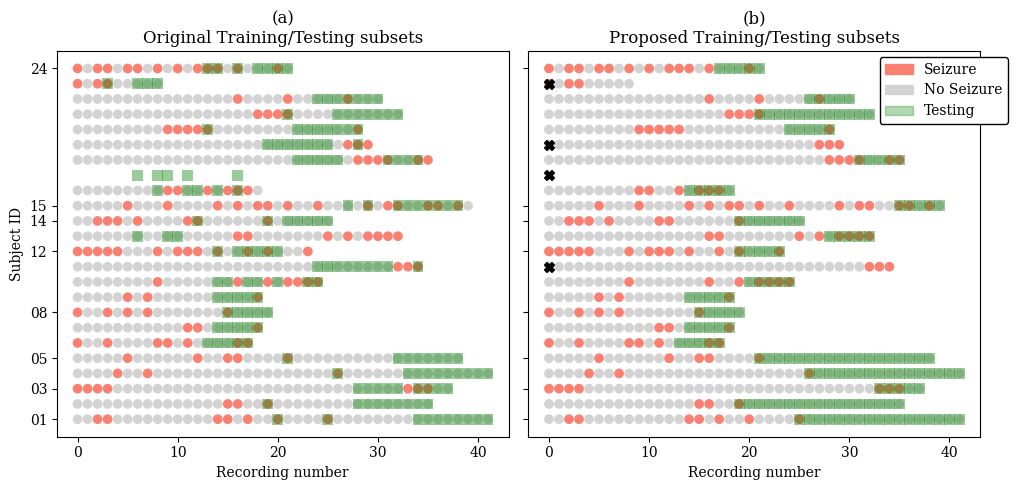

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Define some constants used across the plots
squaresize          = 60
squarealpha         = 0.4
seizure_color       = 'salmon'
nonseizure_color    = 'lightgray'
testing_color       = 'green'

# Change the fint style to serif to match the font family of the repor
plt.rcParams["font.family"] = "serif"
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=True)

# First plot the original disposition
for subject in subjects:
    offset  = int(subject)                                  # The offset in the plot will represent the subject ID
    seiz    = np.asarray(subjects[subject]['seizures'])     # Recordings with at least one seizure will be highlighted
    x       = range(len(seiz))                              # Set the x-domain (a least of recordings for each subject)
    points  = [offset for _ in seiz]                        # Set the final points. 
    color   = [ seizure_color if s > 0 else nonseizure_color for s in seiz ] # Assign color depending on the presence of seizures

    # Scatter the recordings. 
    axs[0].scatter(x, points, color=color)

    # Highlight the recordings used for testing
    subject_idx = int(subject)
    test_x = []
    test_y = []
    for i in range(len(all_subject_labels[subject_idx-1])):
        if all_subject_labels[subject_idx-1][i] == LABEL_TEST: # If the recording was marked as TEST, the add a highlight to that point
            test_x.append(i)
            test_y.append(subject_idx)
    axs[0].scatter(test_x, test_y, color=testing_color, marker="s", s=squaresize, alpha=squarealpha, edgecolors='none')

axs[0].set_xlabel("Recording number")
axs[0].set_ylabel("Subject ID")
axs[0].set_title("(a)\nOriginal Training/Testing subsets");


# Secondly, plot the proposed division

for subject in subjects:
    offset  = int(subject)                                  # The offset in the plot will represent the subject ID
    seiz    = np.asarray(subjects[subject]['seizures'])     # Recordings with at least one seizure will be highlighted
    x       = range(len(seiz))                              # Set the x-domain (a least of recordings for each subject)
    points  = [offset for _ in seiz]                        # Set the final points. 
    color   = [ seizure_color if s > 0 else nonseizure_color for s in seiz ] # Assign color depending on the presence of seizures

    # Scatter the recordings
    axs[1].scatter(x, points, color=color)

    if subjects[subject]["test"] != IMPOSSIBLE_SET: 
        test_x = range(subjects[subject]["test"],len(seiz)) # If the recording was marked as TEST, the add a highlight to that point
        test_y = [ offset for _ in test_x ]
        axs[1].scatter(test_x, test_y, color=testing_color, marker="s", s=squaresize, alpha=squarealpha, edgecolors='none')
    else: 
        # Mark impossible sets with a cross
        axs[1].scatter([0],[offset], color='k', marker='X', s=50)

axs[1].set_xlabel("Recording number")
axs[1].set_title("(b)\nProposed Training/Testing subsets")

# Mark in the labels of only the subjects used in the baseline publication
axs[0].set_yticks(SUBJECT_SUBSET)
axs[0].set_yticklabels([ f"{x:02d}" for x in SUBJECT_SUBSET ])


import matplotlib.patches as mpatches
# Create custom legend handles and labels
legend_handles = [mpatches.Circle((0, 0), 1, color=seizure_color, label='Seizure'),
                  mpatches.Circle((0, 0), 1, color=nonseizure_color, label='No Seizure'),
                  mpatches.Circle((0, 0), 1, color=testing_color, alpha = 0.3, label='Testing')]
# Add legend with custom handles and labels
fig.legend(handles=legend_handles, bbox_to_anchor=(1.02, 0.89), fancybox=True, framealpha=1, edgecolor='black');

plt.tight_layout()

## Export the new proposed division

In [41]:
# Each subject gets their own set of train/test files. 
# Note that no validation file is needed as TSCV will be implemented. 
for subject in subjects:
    test_start = subjects[subject]["test"] 
    if test_start != IMPOSSIBLE_SET:
        # As all testing sets are continous, the only needed information is the starting point. 
        recs_to_train   = list(subjects[subject]['sz@rec'].keys())[:test_start]
        recs_to_test    = list(subjects[subject]['sz@rec'].keys())[test_start:]
        
        # Create each subject's folder based on the training file path
        filename = selected_indexes_path \
                    + recording_sumaries_prologue \
                    + subject +"/"\
                    + selected_indexes_name_train
        os.makedirs(os.path.dirname(filename), exist_ok=True)

        # Write the training file
        with open(filename, 'w+') as f:
            for r in recs_to_train:
                # Each line is composed of a relative file: 
                # ...
                # ../clean_signals/chb05/chb05_35
                # ...
                line = selected_indexes_prologue +subject+"/chb"+ subject + "_" + r + "\n"
                f.write(line)
        
        # Do the same for the test file
        filename = selected_indexes_path \
                    + recording_sumaries_prologue \
                    + subject +"/"\
                    + selected_indexes_name_test

        with open(filename, 'w+') as f:
            for r in recs_to_test:
                line = selected_indexes_prologue +subject+"/chb"+ subject + "_" + r + "\n"
                f.write(line)


# Plotting training and testing results

The training of the model works in data segments. These are fractions/merges of recordings that are fed to the training scheme. In TSCV, training is performed by adding a new segment to the training set, and validating with the following segment. 

The number of segments drastically affect the duration of the training/validation process as after each segment, the training is repeated. 

One approach to reduce the duration of the process is to limit the number of segments used for training to a rolling window. Then, the training time is dependent on both the number of segments and the window lenght. The full TSCV approach is a special case of this, where the window length is equal to the total number of segments. 

----

Segments are an acumulation of batches. Each batch is a small fraction of a recording that is used as an individual input into the training scheme. For example, training the model on segments 3-5 implies feeding the training scheme with batches 702-1170 and validating over the batches 1171-1404. 

## Plotting results
> For the sake of breviety, an extensive evaluation of results was only performed on subject `chb05`, which was seen to be representative of the sub-set of subjects of the baseline publication. 

Firstly, to analyze the effect of the presence of seizures in the segments, the timing information of seizures in recordings is extracted from the summary files, in a similar fashion to that of the extraction of seizure count for the previous plot. 

In [42]:
SECONDS_IN_AN_HOUR = 3600

subject_name = '05'
filename = recording_sumaries_path \
            + recording_sumaries_prologue \
            + subject_name \
            + recording_sumaries_epilogue

# Open the summary file of the representative subject
with open(filename) as f:
    data = f.readlines()

# detect the start and end time of each seizure (this subject has at most 1 seizure per recording)
rec = 0
szs = []
for l in data:
    if l.startswith(line_recording_name_start):
        rec += 1
    if l.startswith(line_seizures_time_start):
        s = int(l[len(line_seizures_time_start):-len(line_seizures_seconds)].strip())
    if l.startswith(line_seizures_time_end):
        e = int(l[len(line_seizures_time_end):-len(line_seizures_seconds)].strip())
        print(f"Seizure in record {rec}:\tseconds {s}-{e}")
        szs.append( [rec, s, e ] )  

# Recognize the presence of seizures in the training segments (as the testing segment is guaranteed to have a seizure, by definition of our proposal division)
train_recs = subjects[subject_name]['test']-1
total_seconds = train_recs*SECONDS_IN_AN_HOUR
print(f"Total recordings on training: {train_recs} = {total_seconds} seconds")

Seizure in record 6:	seconds 417-532
Seizure in record 13:	seconds 1086-1196
Seizure in record 16:	seconds 2317-2413
Seizure in record 17:	seconds 2451-2571
Seizure in record 22:	seconds 2348-2465
Total recordings on training: 20 = 72000 seconds


# Obtain the batched data
In order to obtain in this notebook the segmentation information, we propose running the script `baseline/keras_pipeline/extract_cv_segments` that will generate a `pickle` that can then be loaded in this notebook. 

In [43]:
import pickle
with open("baseline/keras_pipeline/python/dg.pkl", 'rb') as p:
    dg = pickle.load(p)

print(f"The whole data-set was divided into {len(dg)} batches.")

The whole data-set was divided into 2343 batches.


## Obtain whether each segment has a seizure or not
This requires coordination with the `baseline/keras_pipeline/python/train_recurrent_keras.py` file, where the number of segments is defined. 

In [44]:
# Make sure it matches the segment number defined in train_recurrent_keras.py
segments = 10

# Get the batches information
batches             = len(dg)
seconds_per_segment = total_seconds/segments
seg_per_segment     = int(batches/segments)

# Get the absolute time of each seizure (note that recording numbers start in 1, so 1 should be subtracted)
# Note that deepcopy is necessary as the elements of szs are tuples.
import copy
szs_c = copy.deepcopy(szs)
for r in szs_c:
    r[1] += (r[0]-1)*SECONDS_IN_AN_HOUR
    r[2] += (r[0]-1)*SECONDS_IN_AN_HOUR

# Find whether segments contain seizures or not. 
segms = [0]*segments
for b in range(segments):
    segment_start = b*seconds_per_segment
    segment_end = (b+1)*seconds_per_segment
    segms[b] = 0
    for r in szs_c:
        # Seizures are present in the segment if it somehow overlaps with it.
        if (segment_start <= r[1] and segment_end >= r[2] )\
            or (segment_start >= r[1] and segment_start <= r[2] )\
            or (segment_end >= r[1] and segment_end <= r[2] ):
            segms[b] = 1

# Add the testing segments, which is guaranteed to have at least one seizure. 
segms.append(1)

print(f"Segments with seizure: {segms}")

Segments with seizure: [0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1]


## Plot the different CV schemes. 

The results from three different schemes will be presented: 
* **No TSCV** - The whole training set is fed and then testing is performed at the end. 
* **TSCV with 3 segments window** - A time-efficient approach to perform TSCV. Has the drawback of loosing past information in subsequent trainings. 
* **Full TSCV** - The whole past training set is used on each CV epoch. More time consuming but may yield better results.

The plot will include the accuracy and F1 Macro score from the training log. 
> Note that this is NOT the F1 presented in the comparative chart in the report/publication. This is the arithmetic mean between the F1 scores per class.



Text(0, 0.5, 'Accuracy')

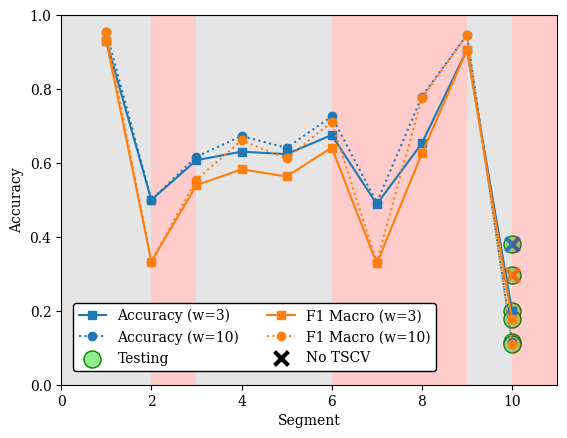

In [46]:
# Open the training log of the TSCV with a window of 3 segments.
with open("baseline/keras_pipeline/scripts/keras_experiments/chb05_tscv_w3/training.log",'r') as f:
    data = f.readlines()

# Append the last two values of each row, namely accuracy and F1 Macro 
accs_tscv = []
f1s_tscv = []
for li in range(1,len(data)-1):
    l = data[li]
    pieces = l.split(',')
    accs_tscv.append(float(pieces[-2].strip()))
    f1s_tscv.append(float(pieces[-1].strip()))
    
# Add the testing results. These values are obtained from the test log: baseline/keras_pipeline/scripts/log/chb05_test_tscv_w3.err
# ...
#  -- All channels involved (combined for each timestamp) --
# Test accuracy : 0.1999767450873997
# Test macro f1-score : 0.17688391584057025
# ...
test_acc_tscv    = 0.200
test_f1_tscv     = 0.177
accs_tscv.append(test_acc_tscv)
f1s_tscv.append(test_f1_tscv)


# Do the same for the TSCV with the full history
with open("baseline/keras_pipeline/scripts/keras_experiments/chb05_tscv_w10/training.log",'r') as f:
    data = f.readlines()

accs_ftscv = []
f1s_ftscv = []
for li in range(1,len(data)-1):
    l = data[li]
    pieces = l.split(',')
    accs_ftscv.append(float(pieces[-2].strip()))
    f1s_ftscv.append(float(pieces[-1].strip()))

# These values are obtained from the test log: baseline/keras_pipeline/scripts/log/chb05_test_tscv_w10.err
test_acc_ftscv    = 0.116
test_f1_ftscv     = 0.110
accs_ftscv.append(test_acc_ftscv)
f1s_ftscv.append(test_f1_ftscv)


import matplotlib.pyplot as plt
# Change the font to serif
plt.rcParams["font.family"] = "serif"
fig, ax = plt.subplots()

# Rolling window TSCV (window=3)  
ax.plot(range(1,len(accs_tscv)+1),  accs_tscv,  marker='s')
ax.plot(range(1,len(accs_ftscv)+1), accs_ftscv, marker='o', color='#1f77b4', linestyle=':' )

# Test results highlight (done before the rest for simplicity in the legend
ax.scatter(len(accs_tscv), test_acc_tscv, marker='o', s=150, linewidth=1, edgecolors='green', color='lightgreen' )

# Full TSCV (window = 10)
ax.plot(range(1,len(accs_tscv)+1),  f1s_tscv,   marker='s')
ax.plot(range(1,len(accs_ftscv)+1), f1s_ftscv,  marker='o', color='#ff7f0e', linestyle=':' )

# Add a dummy marker just for the legend
ax.scatter(-1, 1, marker='x', s=100, linewidth=3, color='k' )

# Testing markers
ax.scatter(len(accs_tscv), test_f1_tscv,    marker='o', s=150, linewidth=1, edgecolors='green', color='lightgreen' )
ax.scatter(len(accs_tscv), test_acc_ftscv,  marker='o', s=150, linewidth=1, edgecolors='green', color='lightgreen' )
ax.scatter(len(accs_tscv), test_f1_ftscv,   marker='o', s=150, linewidth=1, edgecolors='green', color='lightgreen' )

# Add the markers for the run without TSCV
test_acc_nocv = 0.38
test_f1_nocv = 0.296
ax.scatter(len(accs_tscv), test_acc_nocv,   marker='o', s=150, linewidth=1, edgecolors='green', color='lightgreen' )
ax.scatter(len(accs_tscv), test_f1_nocv,    marker='o', s=150, linewidth=1, edgecolors='green', color='lightgreen' )
# Add the test result without CV
ax.scatter(len(accs_tscv), test_acc_nocv,   marker='x', s=100, linewidth=3, edgecolors=None,    color='#1f77b4' )
ax.scatter(len(accs_tscv), test_f1_nocv,    marker='x', s=100, linewidth=3, edgecolors=None,    color='#ff7f0e' )

# Set the limits of the plot (to hide the dummy marker)
ax.set_xlim([0,11])
ax.set_ylim([0,1])

# Add the legend
ax.legend(['Accuracy (w=3)','Accuracy (w=10)',  'Testing', 'F1 Macro (w=3)', 'F1 Macro (w=10)', "No TSCV"],\
            bbox_to_anchor=(0.77, 0.24), \
            fancybox=True, \
            framealpha=1, \
            edgecolor='black', \
            ncol=2)

# Add regions marking in which segments there are seizures and in which not. 
import matplotlib.patches as patches
for b in range(len(segms)): 
    color = "red" if segms[b] == 1 else "gray"
    rect = patches.Rectangle((b, 0), 1, 1, linewidth=0, facecolor=color, alpha=0.2)
    # Add the rectangle to the plot
    ax.add_patch(rect)

ax.set_xlabel("Segment")
ax.set_ylabel("Accuracy")

# Performance metric recomputation

In [58]:
RECS_IN_TEST = 2

import pickle
with open("baseline/keras_pipeline/scripts/res.pkl", 'rb') as p:
    res = pickle.load(p)

yt, yp, acc, cnf, rep, f1 = res

print(len(yt))
print(len(yp))

batches_per_sec = len(yt)/(RECS_IN_TEST*SECONDS_IN_AN_HOUR)
print(f"{batches_per_sec:0.2f} batches per second")



14125
14125
1.96 batches per second
0.0


In [63]:
tp = 0
fp = 0
fn = 0

for t, p in zip(yt, yp):
    if p == 1 and t == 0:
        fp += 1
    elif p == 1 and t == 1:
        tp += 1
    elif p == 0 and t == 1:
        fn += 1

print(fp, tp, fn)

sens = tp / (tp+fn)
prec = tp / (tp + fp)
f1sc = 2*sens*prec / (sens + prec)

print(sens, prec, f1sc)

5432 2033 236
0.8959894226531512 0.272337575351641 0.4177111156770084
